### Optimisez la gestion des données d'une boutique avec R ou Python

# Sommaire :
 - <a href="#C8">Préambule</a>
 - <a href="#C1">Importation des données</a>
 - <a href="#C2">Nettoyage des données</a>
     - Suppression des lignes avec des valeurs manquantes
     - Suppression des doublons
     - Verification de l'unicité des clés 
 - <a href="#C3"> Etablir le lien entre la référence du produit dans l’ERP (product_id) et la       référence du même produit dans la base de la boutique en ligne (SKU)</a> 
 - <a href="#C4">Chiffre d’affaires par produit</a>
 - <a href="#C5">Chiffre d’affaires totales</a>
 - <a href="#C6">Détection d’éventuelles valeurs aberrantes ou atypiques</a>
 - <a href="#C7">Représentation graphique des valeurs aberrantes ou atypiques</a>

# <a name="C8">Préambule</a>

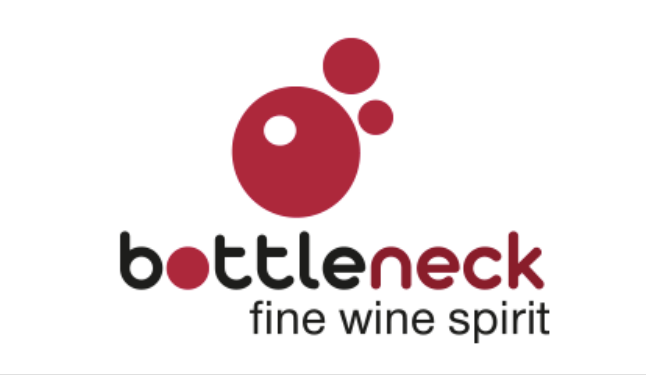

En tant que data analyst freelance chez BottleNeck, le manager Laurent me demande de rapprocher deux exports : un export de l’ERP contenant les références produit, leur prix de vente, leur état de stock et un export contenant les informations des produits commercialisés en ligne (nom, description, nombre de ventes...).

Deuxièmement, une fois le rapprochement effectué, je dois calculer le chiffre d’affaires par produit, ainsi que le total du chiffre d’affaires réalisé en ligne.

Troisièmement et pour finir, on me demande d'effectuer une analyse sur le prix afin de détecter d’éventuelles valeurs aberrantes, de les lister et d’en faire une représentation graphique pour plus de lisibilité et de présenter mes résultats lors de la prochaine réunion de COPIL

Pour ce projet, je vais utiliser le langage de programmation Python pour mener à bien cette analyse.





# <a name="C1">Importation des données</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.metadata
import scipy.stats as stats

In [2]:
!python --version

Python 3.9.12


In [3]:
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

print("matplotlib - ", importlib.metadata.version('matplotlib'))

pandas - 1.4.2
numpy - 1.21.5
seaborn - 0.11.2
matplotlib -  3.5.1


In [4]:
# j'ai converti les fichiers xlsx en fichiers csv  
df_web_store = pd.read_csv('web.csv')
df_erp_store = pd.read_csv('erp.csv')
df_liaison = pd.read_csv('liaison.csv')

In [5]:
df_web_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sku                    1428 non-null   object 
 1   virtual                1513 non-null   int64  
 2   downloadable           1513 non-null   int64  
 3   rating_count           1513 non-null   int64  
 4   average_rating         1430 non-null   float64
 5   total_sales            1430 non-null   float64
 6   tax_status             716 non-null    object 
 7   tax_class              0 non-null      float64
 8   post_author            1430 non-null   float64
 9   post_date              1430 non-null   object 
 10  post_date_gmt          1430 non-null   object 
 11  post_content           0 non-null      float64
 12  post_title             1430 non-null   object 
 13  post_excerpt           716 non-null    object 
 14  post_status            1430 non-null   object 
 15  comm

In [6]:
df_erp_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_id      825 non-null    int64 
 1   onsale_web      825 non-null    int64 
 2   price           825 non-null    object
 3   stock_quantity  825 non-null    int64 
 4   stock_status    825 non-null    object
dtypes: int64(3), object(2)
memory usage: 32.4+ KB


In [7]:
df_liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


## <a name="C2">Nettoyage des données</a>

On a supprimé les doublons et les valeurs nulles avec les fonctions "drop duplicates()" et "dropna()". Dans la base de données ERP, on a remplacé les virgules par des points et changer le type de la colomne en float pour pouvoir calculer le chiffre d'affaires.

In [8]:
# je remplace les ',' par des '.'
df_erp_store["price"]=df_erp_store["price"].str.replace(",", ".")
df_erp_store["price"]=df_erp_store["price"].astype("float")

In [9]:
# On corrige le nom de la colomne id_web dans le fichier liaision
df_liaison.rename(columns={'id_web': 'sku'}, inplace=True)

 - Suppression des lignes avec des valeurs manquantes.


In [10]:
# Je vérifie les lignes de sku qui ne sont pas définies.  
df_web_store[['sku', 'total_sales']].isnull().sum()

sku            85
total_sales    83
dtype: int64

In [11]:
(df_web_store.loc[df_web_store['sku'].isnull(),:])[['sku','total_sales']].sort_values('total_sales', ascending=True)

,sku,total_sales
470,NaN,0.0
471,NaN,0.0
178,NaN,NaN
179,NaN,NaN
227,NaN,NaN
...,...,...
792,NaN,NaN
793,NaN,NaN
794,NaN,NaN
795,NaN,NaN


Après vérification de ces lignes, on peut se permettre de les supprimer parce qu'elles ne contiennent que des valeurs manquantes, dans d'autres cas plus complexes on va contacter le service compétent avant toute action

In [12]:
# je supprime les lignes qui contiennent des valeurs null
df_web=df_web_store[['sku', 'total_sales']].dropna()


In [13]:
df_web[['sku', 'total_sales']].isnull().sum()

sku            0
total_sales    0
dtype: int64

- Suppression des doublons

In [14]:
#j'affiche les doublons
df_web.loc[df_web[['sku','total_sales']].duplicated(keep=False),:]

,sku,total_sales
0,bon-cadeau-25-euros,10.0
1,15298,6.0
2,15296,0.0
3,15300,0.0
4,19814,3.0
...,...,...
1508,16135,5.0
1509,15891,0.0
1510,15887,0.0
1511,13127-1,0.0


In [15]:
# je supprime les doubblons 
df_web.drop_duplicates(subset=['sku'], inplace=True)
display(df_web)

,sku,total_sales
0,bon-cadeau-25-euros,10.0
1,15298,6.0
2,15296,0.0
3,15300,0.0
4,19814,3.0
...,...,...
762,16135,5.0
767,15891,0.0
768,15887,0.0
797,13127-1,0.0


- Verification de l'unicité des clés

In [16]:
df_web['sku'].duplicated().sum() 


0

In [17]:
df_erp_store['product_id'].duplicated().sum()

0

## <a name="C3">Etablir le lien entre la référence du produit dans l’ERP (product_id) et la       référence du même produit dans la base de la boutique en ligne (SKU)</a>

Un premier temps, on a réalisé la liaison entre les tableaux 'liaison' et 'web' avec la clé 'sku' et stocker le resultat dans un dataframe, qu'on va l'utiliser à son tour, pour faire la liasion avec le tableau 'ERP', avec cette fois ci la clé 'product_id.
Après ces deux opérations, j'ai stocké le résultat dans une variable que j'ai nommé 'df_store'.

In [18]:
df_web_liaison = pd.merge(df_web, df_liaison, on='sku', how='left',indicator=True)
df_web_liaison

,sku,total_sales,product_id,_merge
0,bon-cadeau-25-euros,10.0,4954,both
1,15298,6.0,3847,both
2,15296,0.0,3849,both
3,15300,0.0,3850,both
4,19814,3.0,4032,both
...,...,...,...,...
709,16135,5.0,6930,both
710,15891,0.0,7023,both
711,15887,0.0,7025,both
712,13127-1,0.0,7247,both


In [19]:
(df_web_liaison['_merge']!='both').sum()

0

In [20]:
df_web_liaison.drop(['_merge'], axis = 1, inplace=True)

In [21]:
df_store = pd.merge(df_web_liaison, df_erp_store, on='product_id',indicator=True)
df_store[['sku','product_id','total_sales','price','_merge']]

,sku,product_id,total_sales,price,_merge
0,bon-cadeau-25-euros,4954,10.0,25.0,both
1,15298,3847,6.0,24.2,both
2,15296,3849,0.0,34.3,both
3,15300,3850,0.0,20.8,both
4,19814,4032,3.0,14.1,both
...,...,...,...,...,...
709,16135,6930,5.0,8.4,both
710,15891,7023,0.0,27.5,both
711,15887,7025,0.0,69.0,both
712,13127-1,7247,0.0,54.8,both


In [22]:
(df_store['_merge']!='both').sum()

0

In [23]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 713
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sku             714 non-null    object  
 1   total_sales     714 non-null    float64 
 2   product_id      714 non-null    int64   
 3   onsale_web      714 non-null    int64   
 4   price           714 non-null    float64 
 5   stock_quantity  714 non-null    int64   
 6   stock_status    714 non-null    object  
 7   _merge          714 non-null    category
dtypes: category(1), float64(2), int64(3), object(2)
memory usage: 45.5+ KB


## <a name="C4">Chiffre d’affaires par produit</a>
Pour obtenir le chiffre d'affaires de chaque produit, on a  multiplié son prix par son nombre de vente réalisé.

In [24]:
df_store['chiff_aff']= df_store['total_sales']*df_store['price']

df_store[['sku','product_id','chiff_aff']].sort_values('chiff_aff', ascending=False).head(10)

,sku,product_id,chiff_aff
195,7818,4334,4704.0
72,1662,4144,4263.0
219,3510,4402,2288.0
71,11641,4142,1590.0
70,304,4141,1560.0
202,12589,4355,1391.5
200,15940,4352,1125.0
80,16237,4153,1044.0
651,16580,6206,1033.2
31,16416,4068,1029.2


## <a name="C5">Chiffre d’affaires totales</a>
Le chiffre d'affaires totales est la somme des chiffres d'affaires de chaque produit.

In [25]:
chiff_aff=(df_store['total_sales']*df_store["price"]).sum()
print('Le chiffre d\'affaire est de',chiff_aff,'€') 

Le chiffre d'affaire est de 70568.6 €


## <a name="C6">Détection d’éventuelles valeurs aberrantes ou atypiques</a>
On a utilisé la méthode de l'écart interquartile pour détecter assez facilement les outliers.


In [26]:
df_store['price'].describe()

count    714.000000
mean      32.493137
std       27.810525
min        5.200000
25%       14.100000
50%       23.550000
75%       42.175000
max      225.000000
Name: price, dtype: float64

In [27]:
Q1 = np.percentile(df_store['price'], 25, interpolation = 'midpoint') 
Q3 = np.percentile(df_store['price'], 75, interpolation = 'midpoint') 
IQR = Q3 - Q1 
print('IQR',IQR.round(2)) 
print('Q3',Q3.round(2)) 
print('Q1',Q1.round(2)) 

IQR 28.05
Q3 42.15
Q1 14.1


La relation 'Q3 + 1.5 * IQR' permet de mesurer la limite supérieur de la boite à moustache, avec IQR présente l'écart interquartile et Q3 le quartile supérieur; et La relation 'Q1 - 1.5 * IQR'permet de mesurer la limite inférieur de la boite à moustache de la moustache.

In [28]:
val_atyp=(Q3+1.5*IQR).round(2)
print(val_atyp,'est la limite supérieur de la boite')

84.22 est la limite supérieur de la boite


In [29]:
val_atyp_inf=(Q1-1.5*IQR).round(2)
print(val_atyp_inf,'est la limite inférieur de la boite')

-27.98 est la limite inférieur de la boite


In [30]:
# Je sélectionne les valeurs du "prix" qui sont Au-delà de la limite supérieure de la case, ces valeurs sont considérées comme des valeurs atypiques.
display(df_store.loc[df_store['price'] >= val_atyp, ('sku','price')].sort_values('price', ascending=False))

,sku,price
200,15940,225.0
426,14581,217.5
587,14983,191.3
219,3510,176.0
553,15185,175.0
222,7819,157.0
382,14220,137.0
642,14923,135.0
202,12589,126.5
511,14915,124.8


## <a name="C7">Représentation graphique des valeurs aberrantes ou atypiques</a>

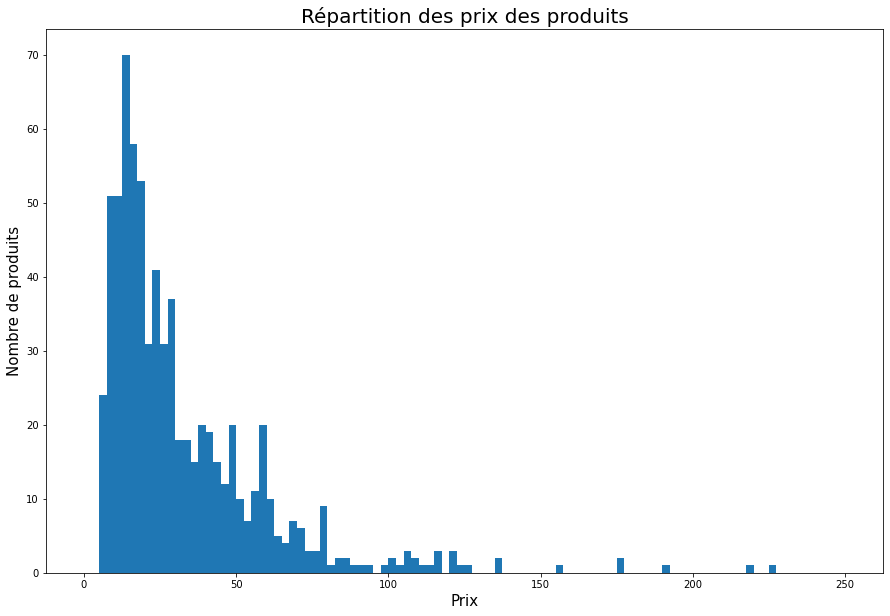

In [31]:
plt.figure(figsize=(15,10))
plt.hist(df_store.price,range = (0,250),bins=100)
plt.title('Répartition des prix des produits', fontsize=20)
plt.xlabel("Prix",fontsize=15)
plt.ylabel("Nombre de produits",fontsize=15)
plt.style.use('ggplot')
plt.show()

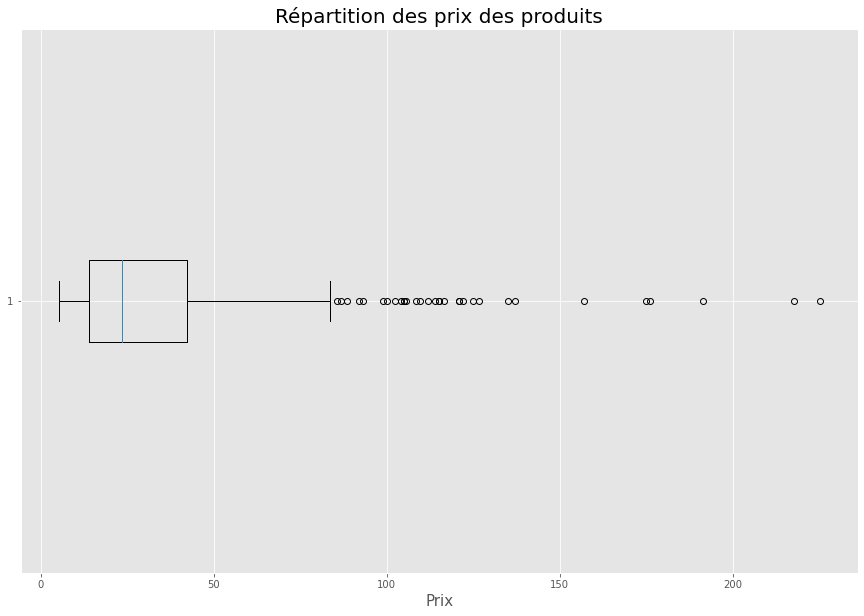

In [32]:
plt.figure(figsize=(15,10))
plt.boxplot(df_store["price"], vert=False)
plt.xlabel("Prix",fontsize=15)
plt.title('Répartition des prix des produits', fontsize=20)
plt.style.use('ggplot')
plt.show()

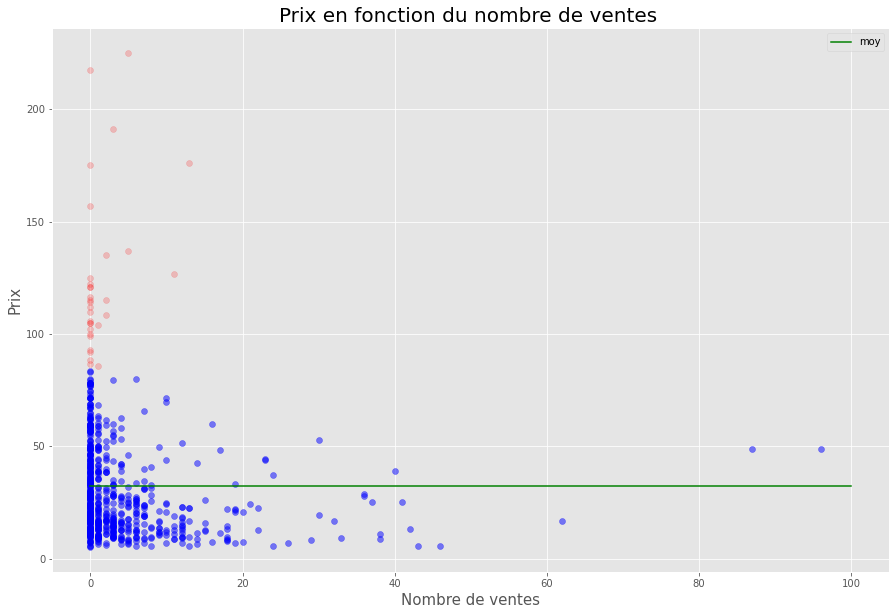

In [33]:
plt.figure(figsize=(15,10))
y1 = df_store.loc[df_store['price'] > val_atyp, 'price']
y2 = df_store.loc[df_store['price'] < val_atyp, 'price']
x1 = df_store.loc[df_store['price'] > val_atyp, 'total_sales']
x2 = df_store.loc[df_store['price'] < val_atyp, 'total_sales']
plt.xlabel("Nombre de ventes",fontsize=15)
plt.ylabel("Prix", fontsize=15)
plt.title('Prix en fonction du nombre de ventes ', fontsize=20)
plt.plot([100,0], [df_store['price'].mean(), df_store['price'].mean()], color = 'green', linestyle = 'solid')
plt.legend(['moy'], loc= 'upper right')
plt.scatter(x1, y1, c = 'red',alpha=0.2)
plt.scatter(x2, y2, c = 'blue',alpha=0.5)






